# LIKWID Profiles Summary (Multiple Apps)

Aggregate LIKWID `.prof` files across policies for multiple app folders
and plot bar charts for selected metrics in a shared figure.


In [17]:
# User inputs
app_configs = [
    {
        'label': 'AMG',
        'root': 'AMG/AMDzen4c',
        'benchmarks': ['amg'],
    },
    {
        'label': 'HPCG',
        'root': 'HPCG/AMDzen4c',
        'benchmarks': ['hpcg'],
    },
    {
        'label': 'miniAMR',
        'root': 'miniAMR/AMDzen4c',
        'benchmarks': ['miniAMR'],
    },
    {
        'label': 'PENNANT',
        'root': 'PENNANT/AMDzen4c',
        'benchmarks': ['pennant'],
    },
    # {
    #     'label': 'SNAP',
    #     'root': 'SNAP/AMDzen4c',
    #     'benchmarks': ['snap'],
    # },
    {
        'label': 'specfem3D',
        'root': 'specfem3D/AMDzen4c',
        'benchmarks': ['specfem3D'],
    },
    {
        'label': 'SPEChpc',
        'root': 'SPEChpc/AMDzen4c/job-submit',
        'benchmarks': [
            'clvleaf',
            'hpgmgfv',
            'lbm',
            'miniswp',
            'pot3d',
            'soma',
            'sph_exa',
            'tealeaf',
            'weather',
        ],
    },
]
metrics_to_plot = [
    'Total Runtime',
    # 'Average Core Power [W]',
    # 'Average L3 Power [W]',
    'Average Power',
    'Total Energy',
    'EDP',
]
policy_folders = ['2.25GHz', 'ondemand', 'performance', 'everest', 'DVFS-energy']
policy_order = ['2.25GHz', 'ondemand', 'performance', 'everest', 'DVFS-energy']  # set to None to keep default order
skip_initial = 3  # drop the first N samples if they are noisy

colors = ["#867FCA", '#F29856', '#76A98F','#4C78A8', '#DA595B'] #, '#F58518', '#54A24B', '#E45756', '#72B7B2']
hatches = ['xxx', '\\\\\\', 'oo', '///', '++']

In [18]:
from __future__ import annotations

from pathlib import Path
from typing import Dict, List, Sequence

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
plt.rcParams['hatch.linewidth'] = 0.3

SUM_FIELDS = {
    'Energy [J]',
    'Power [W]',
    'Energy PP0 [J]',
    'Power PP0 [W]',
    'Energy DRAM [J]',
    'Power DRAM [W]',
    'Energy PLATFORM [J]',
    'Power PLATFORM [W]',
    'Memory read bandwidth [MBytes/s]',
    'Memory read data volume [GBytes]',
    'Memory write bandwidth [MBytes/s]',
    'Memory write data volume [GBytes]',
    'Memory bandwidth [MBytes/s]',
    'Memory data volume [GBytes]',
    'L3 request rate',
    'L3 miss rate',
    'L3 miss ratio',
    'Energy Core [J]',
    'Power Core [W]',
    'Energy L3 [J]',
    'Power L3 [W]',
}


def extract_job_id(path: Path | str) -> str:
    name = path.name if isinstance(path, Path) else Path(path).name
    parts = name.split('.')
    if len(parts) < 3:
        raise ValueError(f'Could not infer job id from {name}')
    return parts[-2]


def _stdout_candidates(folder: Path, job_id: str) -> List[Path]:
    pattern = f'*.{job_id}.out'
    matches = sorted(folder.rglob(pattern))
    return [
        path
        for path in matches
        if 'timeline' not in path.name and not path.name.startswith('likwid_')
    ]


def find_stdout_for_job(base_dir: Path, job_id: str) -> Path:
    search_roots = [base_dir, base_dir.parent]
    candidates: List[Path] = []
    for root in search_roots:
        if root.exists():
            candidates.extend(_stdout_candidates(root, job_id))
    if not candidates:
        raise FileNotFoundError(f'No stdout file found for job {job_id} under {base_dir.parent}')
    candidates = sorted(candidates)
    if len(candidates) > 1:
        # print(f'Multiple stdout candidates found; using {candidates[0]}')
        pass
    return candidates[0]


def parse_headers(stdout_path: Path) -> List[Sequence[str]]:
    headers: List[Sequence[str]] = []
    with stdout_path.open() as handle:
        for line in handle:
            if line.startswith('# GID|'):
                parts = line.lstrip('#').strip().split('|')
                fields = parts[3:]
                if fields:
                    headers.append(fields)
    if not headers:
        raise RuntimeError(f'No LIKWID headers found in {stdout_path}')
    return headers


def aggregate_metric(values: Sequence[float], field: str) -> float:
    if not values:
        raise KeyError(f'Missing values for field {field}')
    if field in SUM_FIELDS:
        return float(sum(values))
    return float(sum(values) / len(values))


def load_likwid_profile(profile_path: Path, stdout_path: Path, *, skip_initial: int = 0) -> pd.DataFrame:
    headers = parse_headers(stdout_path)
    if len(headers) > 1:
        print(f'Warning: expected 1 header set, found {len(headers)} in {stdout_path.name}')
    header = headers[0]
    global_field = header[0]
    metric_fields = header[1:]

    rows: List[Dict[str, float]] = []
    with profile_path.open() as handle:
        for raw_line in handle:
            line = raw_line.strip()
            if not line or not line[0].isdigit():
                continue
            parts = line.split(',')
            if len(parts) < 4:
                continue
            gid = int(parts[0])
            metrics_count = int(parts[1])
            cpu_count = int(parts[2])
            values = [float(val) for val in parts[3:]]

            if metrics_count != len(metric_fields):
                raise ValueError(
                    f'Header mismatch: expected {len(metric_fields)} metrics, got {metrics_count} in {profile_path.name}'
                )

            expected_values = 1 + metrics_count * cpu_count
            if len(values) != expected_values:
                raise ValueError(
                    f'Expected {expected_values} numeric entries, got {len(values)} in {profile_path.name}'
                )

            global_value = values[0]
            metric_values = values[1:]

            extracted: Dict[str, float] = {global_field: global_value}
            for idx, field in enumerate(metric_fields):
                start = idx * cpu_count
                end = start + cpu_count
                segment = metric_values[start:end]
                if not segment:
                    continue
                extracted[field] = aggregate_metric(segment, field)

            extracted['gid'] = gid
            rows.append(extracted)

    if not rows:
        raise RuntimeError(f'No LIKWID samples parsed from {profile_path.name}')

    if skip_initial:
        rows = rows[skip_initial:]

    df = pd.DataFrame(rows).reset_index(drop=True)
    df.index.name = 'sample_index'
    return df


def summarize_profile(df: pd.DataFrame) -> Dict[str, float]:
    required_fields = [
        'Power Core [W]',
        'Power L3 [W]',
    ]
    missing = [field for field in required_fields if field not in df.columns]
    if missing:
        raise ValueError(f'Missing columns for power/energy calculations: {missing}')

    if 'Total Runtime' in df.columns:
        time_axis = df['Total Runtime']
        total_runtime = float(time_axis.iloc[-1])
    else:
        time_axis = df.index
        total_runtime = float(time_axis[-1] - time_axis[0]) if len(time_axis) > 1 else 0.0

    time_values = time_axis.to_numpy()
    core_power = df['Power Core [W]'].to_numpy()
    l3_power = df['Power L3 [W]'].to_numpy()

    avg_core_power = float(df['Power Core [W]'].mean())
    avg_l3_power = float(df['Power L3 [W]'].mean())
    avg_total_power = avg_core_power + avg_l3_power

    if len(time_values) > 1:
        dt = time_values[1:] - time_values[:-1]
        total_core_energy = float((core_power[:-1] + core_power[1:]).dot(dt) / 2.0)
        total_l3_energy = float((l3_power[:-1] + l3_power[1:]).dot(dt) / 2.0)
    else:
        total_core_energy = 0.0
        total_l3_energy = 0.0

    total_energy = total_core_energy + total_l3_energy
    edp = total_energy * total_runtime

    return {
        'Total Runtime': total_runtime,
        'Average Core Power [W]': avg_core_power,
        'Average L3 Power [W]': avg_l3_power,
        'Average Power': avg_total_power,
        'Total Core energy [J]': total_core_energy,
        'Total L3 energy [J]': total_l3_energy,
        'Total Energy': total_energy,
        'EDP': edp,
    }


def list_profiles(profiles_dir: Path) -> pd.DataFrame:
    profile_paths = sorted(profiles_dir.glob('*.prof'))
    profile_table = []
    for path in profile_paths:
        parts = path.stem.split('.')
        name = parts[0].removeprefix('spechpc_')
        job = parts[1] if len(parts) > 1 else ''
        profile_table.append({'benchmark': name, 'job_id': job, 'path': path})
    return pd.DataFrame(profile_table).sort_values(['benchmark', 'job_id'])


def newest_profile_for_benchmark(profiles_df: pd.DataFrame, benchmark: str) -> Path:
    match = profiles_df[profiles_df['benchmark'] == benchmark]
    if match.empty:
        raise ValueError(f'No profiles found for benchmark {benchmark}')
    match = match.sort_values('job_id')
    return Path(match.iloc[-1]['path'])


def summarize_policies(base_dir: Path, policies: List[str], benchmark: str, skip_initial: int) -> pd.DataFrame:
    rows: List[Dict[str, float]] = []
    for policy in policies:
        policy_dir = base_dir / policy
        profiles_dir = policy_dir / 'profiles'
        if not profiles_dir.is_dir():
            print(f'Skipping {policy}: missing profiles directory')
            continue

        profiles_df = list_profiles(profiles_dir)
        profile_file = newest_profile_for_benchmark(profiles_df, benchmark)
        job_id = extract_job_id(profile_file)
        stdout_file = find_stdout_for_job(policy_dir, job_id)

        df = load_likwid_profile(profile_file, stdout_file, skip_initial=skip_initial)
        metrics = summarize_profile(df)
        metrics['policy'] = policy
        rows.append(metrics)

    if not rows:
        raise RuntimeError('No valid profiles found for the selected policies.')
    summary = pd.DataFrame(rows).set_index('policy')
    return summary


def summarize_benchmarks(base_dir: Path, policies: List[str], benchmarks: List[str], skip_initial: int) -> pd.DataFrame:
    rows: List[pd.DataFrame] = []
    for benchmark in benchmarks:
        summary = summarize_policies(base_dir, policies, benchmark, skip_initial)
        summary = summary.reset_index()
        summary['benchmark'] = benchmark
        rows.append(summary)
    if not rows:
        raise RuntimeError('No valid profiles found for the selected benchmarks.')
    merged = pd.concat(rows, ignore_index=True)
    return merged


def format_benchmark_label(app_label: str, benchmark: str, multi_bench: bool) -> str:
    if multi_bench:
        return benchmark
    return app_label


def summarize_app_configs(
    base_dir: Path,
    app_configs: List[Dict[str, object]],
    policies: List[str],
    skip_initial: int,
) -> pd.DataFrame:
    rows: List[pd.DataFrame] = []
    for app in app_configs:
        app_label = str(app['label'])
        app_root = base_dir / str(app['root'])
        benchmarks = list(app['benchmarks'])
        if not app_root.is_dir():
            print(f'Skipping {app_label}: missing {app_root}')
            continue
        summary = summarize_benchmarks(app_root, policies, benchmarks, skip_initial)
        multi_bench = len(benchmarks) > 1
        summary['benchmark'] = [
            format_benchmark_label(app_label, bench, multi_bench)
            for bench in summary['benchmark']
        ]
        rows.append(summary)
    if not rows:
        raise RuntimeError('No valid profiles found for the selected app configs.')
    return pd.concat(rows, ignore_index=True)


def build_benchmark_order(app_configs: List[Dict[str, object]]) -> List[str]:
    ordered: List[str] = []
    for app in app_configs:
        app_label = str(app['label'])
        benchmarks = list(app['benchmarks'])
        multi_bench = len(benchmarks) > 1
        for bench in benchmarks:
            ordered.append(format_benchmark_label(app_label, str(bench), multi_bench))
    return ordered


def plot_benchmark_groups(
    summary: pd.DataFrame,
    metrics: List[str],
    policy_order: List[str] | None,
    benchmark_order: List[str] | None,
    colors_override: List[str] | None = None,
    hatches_override: List[str] | None = None,
) -> None:
    policy_labels = {
        '2.25GHz': 'Fixed 2.25GHz',
        'DVFS-energy': 'PULSE',
        'everest': 'EVeREST',
    }

    for metric in metrics:
        if metric not in summary.columns:
            raise ValueError(f"Metric '{metric}' not found. Available: {sorted(summary.columns)}")

        pivot = summary.pivot(index='benchmark', columns='policy', values=metric)
        if benchmark_order is not None:
            present = [name for name in benchmark_order if name in pivot.index]
            pivot = pivot.reindex(present)
        if policy_order is not None:
            missing = [policy for policy in policy_order if policy not in pivot.columns]
            if missing:
                raise ValueError(f'Missing policies in data: {missing}')
            pivot = pivot[policy_order]
        pivot = pivot.rename(columns=policy_labels)
        palette = colors_override if colors_override is not None else colors
        hatch_set = hatches_override if hatches_override is not None else hatches
        column_colors = [palette[idx % len(palette)] for idx in range(len(pivot.columns))]
        ax = pivot.plot(kind='bar', figsize=(15, 5), color=column_colors, width=0.7, alpha=0.9)
        for col_idx, container in enumerate(ax.containers):
            hatch = hatch_set[col_idx % len(hatch_set)]
            for bar in container:
                bar.set_hatch(hatch)
        # ax.set_title(metric)
        ax.set_ylabel(metric, fontsize=14)
        ax.set_xlabel('')
        ax.tick_params(axis='x', labelrotation=0, labelsize=14)
        ax.grid(axis='y', linestyle='-', alpha=0.3)
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=len(pivot.columns), frameon=False, fontsize=14)
        plt.tight_layout()


In [19]:
base_dir = Path.cwd()
summary_df = summarize_app_configs(base_dir, app_configs, policy_folders, skip_initial)
summary_df


,policy,Total Runtime,Average Core Power [W],Average L3 Power [W],Average Power,Total Core energy [J],Total L3 energy [J],Total Energy,EDP,benchmark
0,2.25GHz,892.0,2.005987,2.622457e+12,2.622457e+12,1790.943547,2.341854e+15,2.341854e+15,2.088934e+18,AMG
1,ondemand,913.0,1.995314,2.477174e+12,2.477174e+12,1823.460435,2.264137e+15,2.264137e+15,2.067157e+18,AMG
2,performance,908.0,1.955301,2.561283e+12,2.561283e+12,1776.938723,2.328206e+15,2.328206e+15,2.114011e+18,AMG
3,everest,984.0,1.838629,2.329789e+12,2.329789e+12,1810.846271,2.294842e+15,2.294842e+15,2.258125e+18,AMG
4,DVFS-energy,1137.0,1.183264,1.501865e+12,1.501865e+12,1346.110350,1.709122e+15,1.709122e+15,1.943272e+18,AMG
...,...,...,...,...,...,...,...,...,...,...
65,2.25GHz,3511.0,3.027434,2.934392e+12,2.934392e+12,10631.754214,1.030558e+16,1.030558e+16,3.618291e+19,weather
66,ondemand,3525.0,3.238411,2.890797e+12,2.890797e+12,11418.325860,1.019295e+16,1.019295e+16,3.593015e+19,weather
67,performance,3508.0,2.379797,2.974024e+12,2.974024e+12,8350.295151,1.043585e+16,1.043585e+16,3.660896e+19,weather
68,everest,3523.0,1.393308,2.281922e+12,2.281922e+12,4909.750863,8.041492e+15,8.041492e+15,2.833018e+19,weather


In [20]:
# Normalize metrics to the 2.25GHz policy (baseline = 1)
baseline_policy = '2.25GHz'
baseline = summary_df[summary_df['policy'] == baseline_policy][['benchmark'] + metrics_to_plot]
baseline = baseline.set_index('benchmark')

normalized_df = summary_df.merge(baseline, on='benchmark', suffixes=('', '_base'))
for metric in metrics_to_plot:
    normalized_df[metric] = normalized_df[metric] / normalized_df[f'{metric}_base']
normalized_df = normalized_df.drop(columns=[f'{metric}_base' for metric in metrics_to_plot])
normalized_df


,policy,Total Runtime,Average Core Power [W],Average L3 Power [W],Average Power,Total Core energy [J],Total L3 energy [J],Total Energy,EDP,benchmark
0,2.25GHz,1.000000,2.005987,2.622457e+12,1.000000,1790.943547,2.341854e+15,1.000000,1.000000,AMG
1,ondemand,1.023543,1.995314,2.477174e+12,0.944600,1823.460435,2.264137e+15,0.966814,0.989575,AMG
2,performance,1.017937,1.955301,2.561283e+12,0.976673,1776.938723,2.328206e+15,0.994172,1.012005,AMG
3,everest,1.103139,1.838629,2.329789e+12,0.888399,1810.846271,2.294842e+15,0.979925,1.080994,AMG
4,DVFS-energy,1.274664,1.183264,1.501865e+12,0.572694,1346.110350,1.709122e+15,0.729816,0.930270,AMG
...,...,...,...,...,...,...,...,...,...,...
65,2.25GHz,1.000000,3.027434,2.934392e+12,1.000000,10631.754214,1.030558e+16,1.000000,1.000000,weather
66,ondemand,1.003987,3.238411,2.890797e+12,0.985144,11418.325860,1.019295e+16,0.989071,0.993015,weather
67,performance,0.999146,2.379797,2.974024e+12,1.013506,8350.295151,1.043585e+16,1.012640,1.011775,weather
68,everest,1.003418,1.393308,2.281922e+12,0.777647,4909.750863,8.041492e+15,0.780304,0.782971,weather


In [21]:
# Performance loss and energy saving vs Fixed 2.25GHz
compare_policies = ['ondemand', 'performance', 'everest', 'DVFS-energy']
baseline_policy = '2.25GHz'

baseline_metrics = summary_df[summary_df['policy'] == baseline_policy][
    ['benchmark', 'Total Runtime', 'Total Energy', 'EDP']
].set_index('benchmark')

compare_df = summary_df[summary_df['policy'].isin(compare_policies)].merge(
    baseline_metrics, on='benchmark', suffixes=('', '_base')
)
compare_df['Runtime loss [%]'] = (
    compare_df['Total Runtime'] / compare_df['Total Runtime_base'] - 1.0
) * 100.0
compare_df['Energy saving [%]'] = (
    1.0 - compare_df['Total Energy'] / compare_df['Total Energy_base']
) * 100.0
compare_df['EDP saving [%]'] = (
    1.0 - compare_df['EDP'] / compare_df['EDP_base']
) * 100.0

result_cols = [
    'benchmark',
    'policy',
    'Runtime loss [%]',
    'Energy saving [%]',
    'EDP saving [%]',
]
performance_energy_df = compare_df[result_cols].sort_values(['benchmark', 'policy'])
performance_energy_df


,benchmark,policy,Runtime loss [%],Energy saving [%],EDP saving [%]
3,AMG,DVFS-energy,27.466368,27.018416,6.973026
2,AMG,everest,10.313901,2.007475,-8.099377
0,AMG,ondemand,2.354260,3.318620,1.042489
1,AMG,performance,1.793722,0.582807,-1.200461
7,HPCG,DVFS-energy,10.037175,34.820832,28.278685
6,HPCG,everest,5.947955,23.309207,18.747673
4,HPCG,ondemand,0.148699,6.872729,6.734250
5,HPCG,performance,-0.074349,23.534894,23.591746
15,PENNANT,DVFS-energy,15.777185,-7.553875,-24.522849
14,PENNANT,everest,8.805871,-0.008036,-8.814615


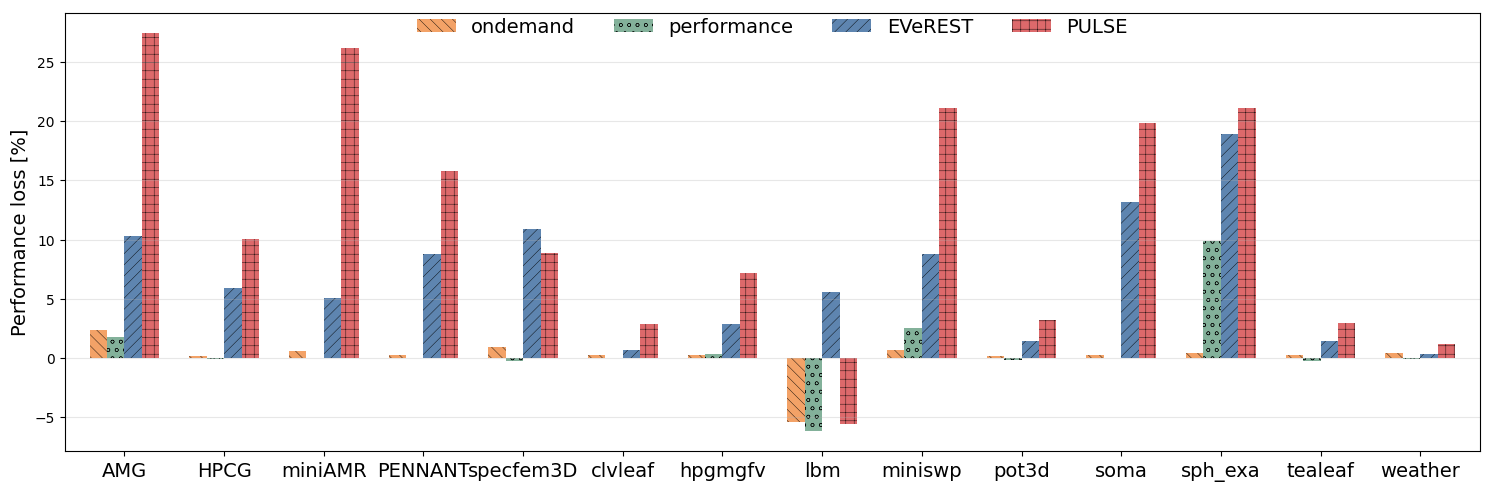

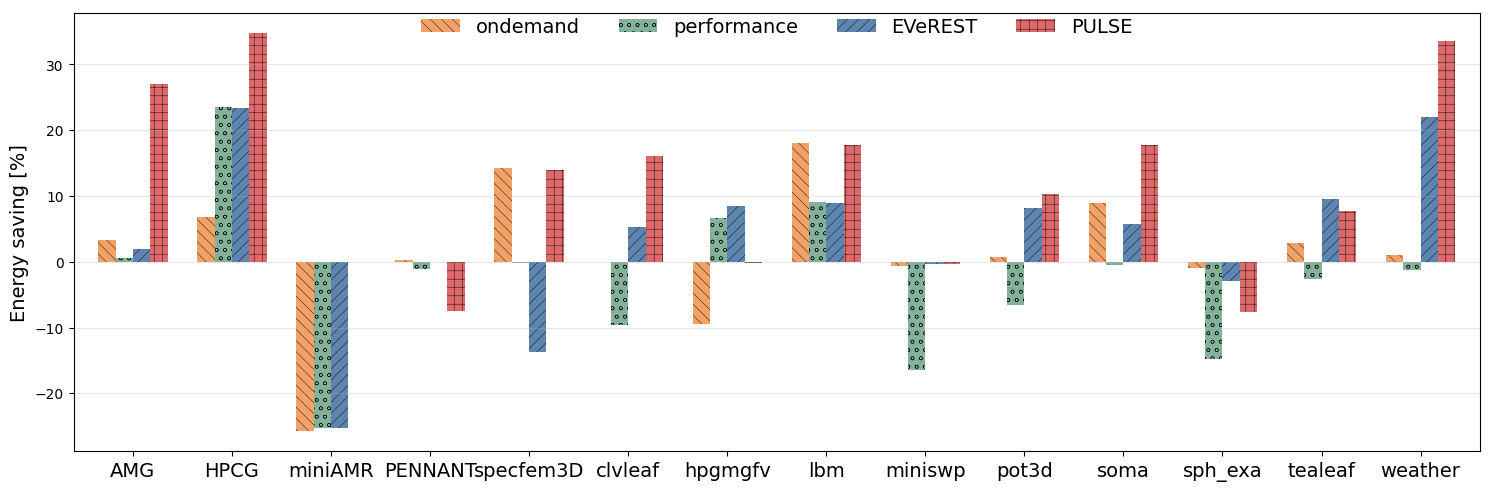

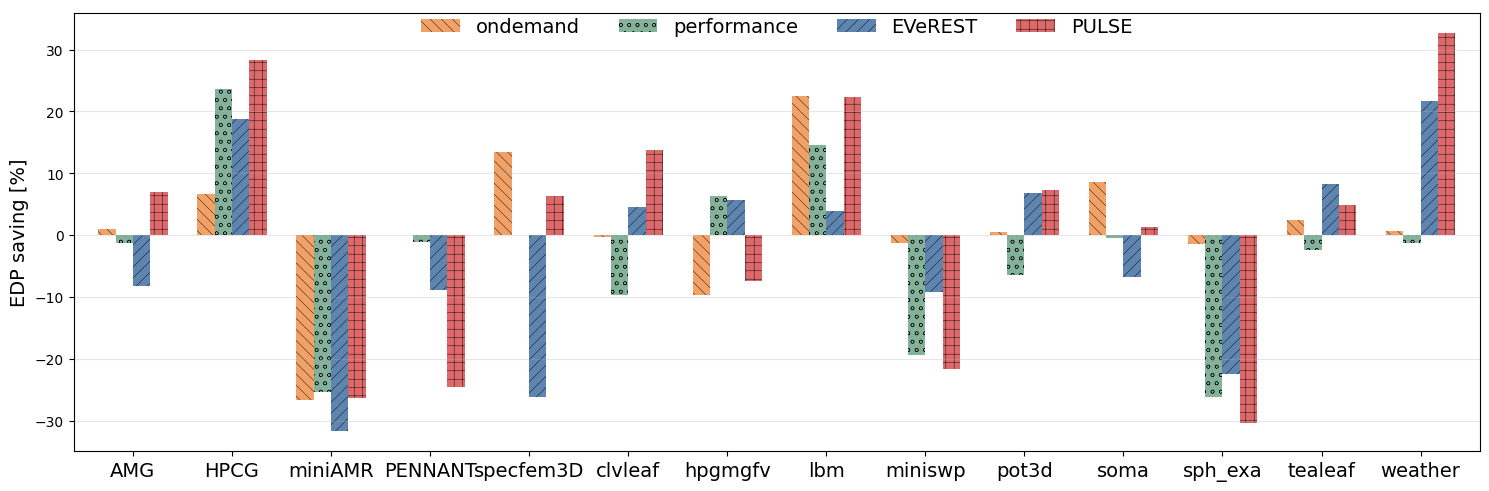

In [22]:
# Plot performance loss and energy saving (same style as existing plots)
perf_energy_plot_df = performance_energy_df.rename(
    columns={'Runtime loss [%]': 'Performance loss [%]'}
)
plot_metrics = ['Performance loss [%]', 'Energy saving [%]', 'EDP saving [%]']
benchmark_order = build_benchmark_order(app_configs)
perf_policy_order = [
    policy for policy in policy_order
    if policy in perf_energy_plot_df['policy'].unique()
]
perf_colors = colors[1:]
perf_hatches = hatches[1:]
plot_benchmark_groups(
    perf_energy_plot_df,
    plot_metrics,
    perf_policy_order,
    benchmark_order,
    colors_override=perf_colors,
    hatches_override=perf_hatches,
)


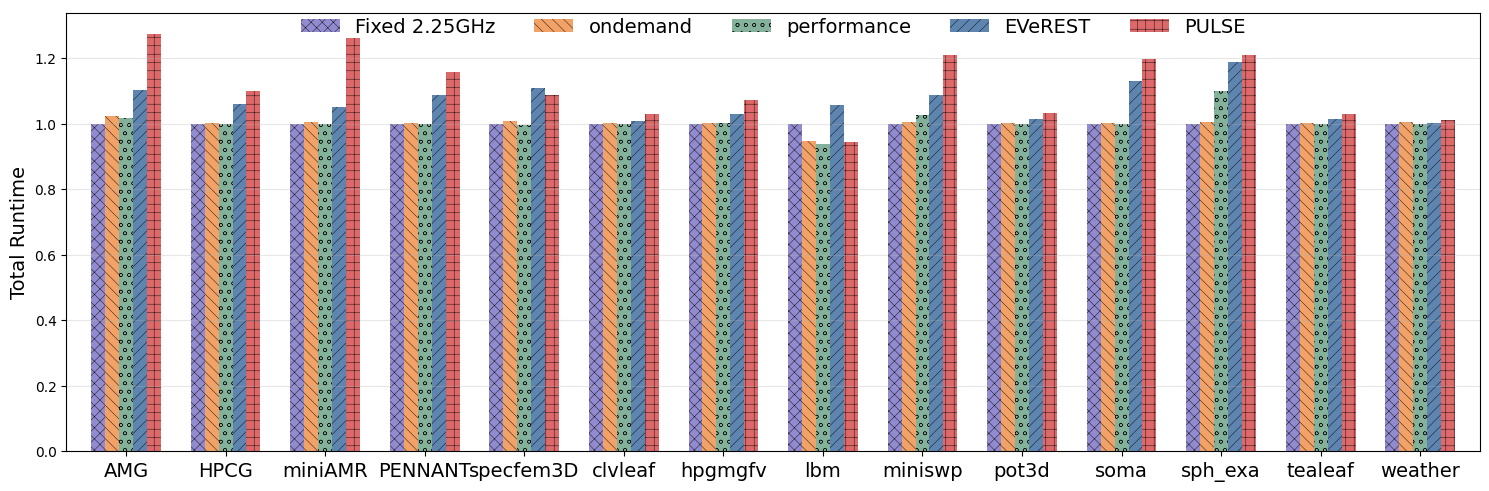

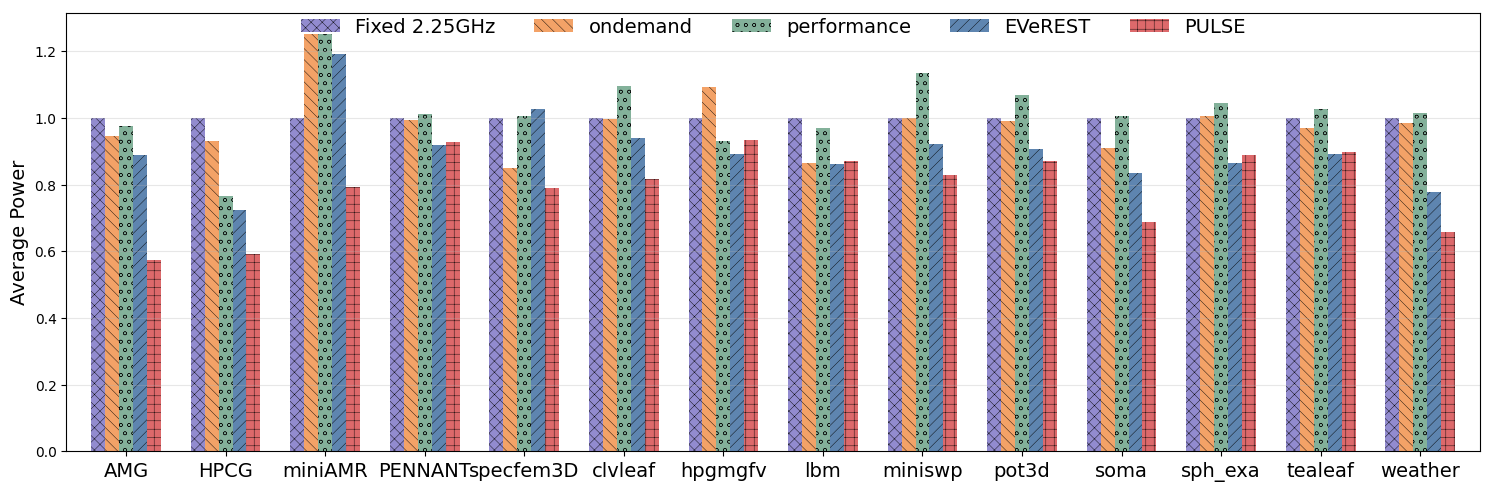

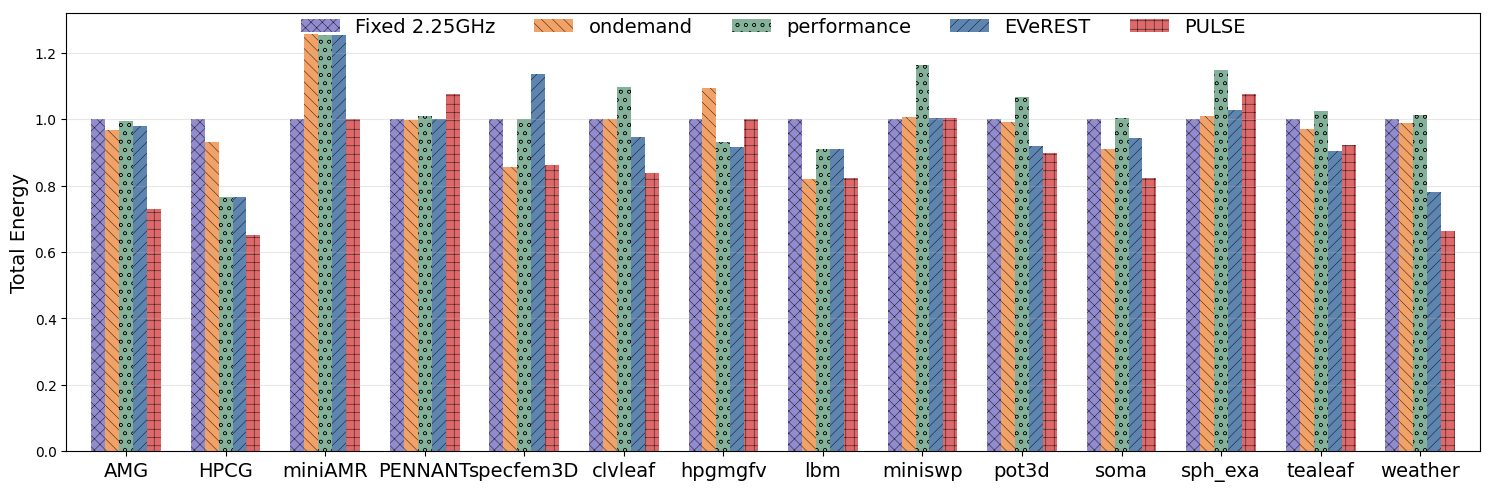

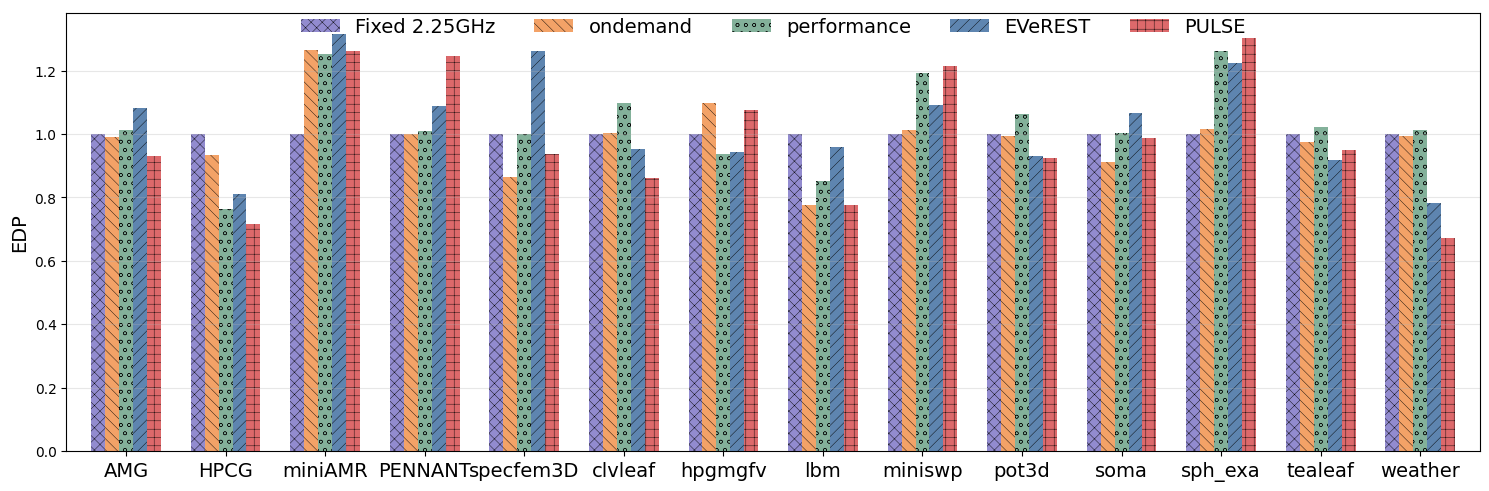

In [23]:
benchmark_order = build_benchmark_order(app_configs)
plot_benchmark_groups(normalized_df, metrics_to_plot, policy_order, benchmark_order)
